In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import time
from sklearn.metrics import mean_squared_error,roc_auc_score,mean_absolute_error,log_loss
import sys
sys.path.append('benchmark/')
from lvxnn_test import lvxnn
from xgb_test import xgb
from svd_test import svd
from deepfm_fm_test import deepfm_fm
from rank_test import rtest
sys.path.append('../')
from lvxnn.LVXNN import LV_XNN
from lvxnn.DataReader import data_initialize
from lvxnn.utils import local_visualize
from lvxnn.utils import global_visualize_density
from lvxnn.utils import feature_importance_visualize
from lvxnn.utils import plot_trajectory
from lvxnn.utils import plot_regularization
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
random_state=0
data= pd.read_csv('data/santander/Santander.csv')

task_type = "Classification"

list1 = data.columns
meta_info = OrderedDict()
for i in list1:
    meta_info[i]={'type': 'categorical','source':'user'}
meta_info['income']={"type":"continues",'source':'user'}
meta_info['cust_seniority']={"type":"continues",'source':'user'}
meta_info['age'] = {"type":"continues",'source':'user'}
meta_info['item'] = {'type': 'categorical','source':'item'}
meta_info['user_id']={"type":"id",'source':'user'}
meta_info['item_id']={"type":"id",'source':'item'}
meta_info['target']={"type":"target",'source':''}
#the best shrinkage is 0.840000
#the best combination is 0.613360
lx_params = {
        "rank":5,
        "main_effect_epochs":30,
        "interaction_epochs" : 30 ,
        "tuning_epochs" : 10 , 
        "mf_training_iters": 50,
        "u_group_num": 50,
        "i_group_num":20,
        "best_shrinkage":1,
        "best_combination":0.4,
        "auto_tune":True,
        "verbose":False
    }

deepfm_fm_params = {
        "epochs":20,
        "loss_type" : 'logloss' ,
        "eval_metric" : log_loss , 
        "greater_is_better": False,
        "verbose":True,
        "early_stopping": True
    }

W0724 11:32:00.337233 31380 deprecation.py:323] From C:\Users\64161\Anaconda3\lib\site-packages\tensorflow_core\python\compat\v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
result_lvxnn = lvxnn('warm',data, meta_info,task_type , random_state=0, params=lx_params)
result_svd = svd('warm',data, meta_info, task_type , random_state=0)
result_deepfm, result_fm = deepfm_fm('warm',data, meta_info,task_type , random_state=0, params=deepfm_fm_params)
result_xgb = xgb('warm',data, meta_info, task_type , random_state=0)

result_sim_std = pd.concat([result_lvxnn,result_svd,result_xgb,result_deepfm,result_fm],0)

result_sim_std.to_csv('santander_result.csv',index=None)

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

Memory usage of dataframe is 52.20 MB
Memory usage after optimization is: 11.27 MB
Decreased by 78.4%
Memory usage of dataframe is 13.05 MB
Memory usage after optimization is: 2.82 MB
Decreased by 78.4%
test cold start user: 14
test cold start item: 0
validation cold start user: 11
validation cold start item: 0
ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
time cost: 221.7295150756836
After the gam stage, training error is 0.05206 , validation error is 0.05249
missing value counts: 535419
#####start auto_tuning#####


C:\Users\64161\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


the best shrinkage is 0.959300
the best combination is 0.438040
#####mf_training#####


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


final num of user group: 1
final num of item group: 1
change mode state : True
time cost: 1800.6842653751373
After the matrix factor stage, training error is 0.00372, validation error is 0.03364
0


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
time cost: 232.28285193443298
After the gam stage, training error is 0.05158 , validation error is 0.05233
missing value counts: 535471
#####mf_training#####


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


final num of user group: 1
final num of item group: 1
change mode state : True
time cost: 43.51034736633301
After the matrix factor stage, training error is 0.00399, validation error is 0.03384
1


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
time cost: 231.92027640342712
After the gam stage, training error is 0.05230 , validation error is 0.05275
missing value counts: 535654
#####mf_training#####


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


final num of user group: 1
final num of item group: 1
change mode state : True
time cost: 45.504186153411865
After the matrix factor stage, training error is 0.00375, validation error is 0.03352
2


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
time cost: 235.4512963294983
After the gam stage, training error is 0.05154 , validation error is 0.05284
missing value counts: 535515
#####mf_training#####


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


final num of user group: 1
final num of item group: 1
change mode state : True
time cost: 43.957536697387695
After the matrix factor stage, training error is 0.00489, validation error is 0.03751
3


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
time cost: 229.66662168502808
After the gam stage, training error is 0.05174 , validation error is 0.05100
missing value counts: 535516
#####mf_training#####


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


final num of user group: 1
final num of item group: 1
change mode state : True
time cost: 41.21672558784485
After the matrix factor stage, training error is 0.00503, validation error is 0.04273
4


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
time cost: 210.97687983512878
After the gam stage, training error is 0.05268 , validation error is 0.05266
missing value counts: 535477
#####mf_training#####


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


final num of user group: 1
final num of item group: 1
change mode state : True
time cost: 40.66955518722534
After the matrix factor stage, training error is 0.00417, validation error is 0.03554
5


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
time cost: 230.96973657608032
After the gam stage, training error is 0.05145 , validation error is 0.05210
missing value counts: 535468
#####mf_training#####


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


final num of user group: 1
final num of item group: 1
change mode state : True
time cost: 13.606778860092163
After the matrix factor stage, training error is 0.00562, validation error is 0.04350
6


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
time cost: 229.1651611328125
After the gam stage, training error is 0.05173 , validation error is 0.05138
missing value counts: 535442
#####mf_training#####


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


final num of user group: 1
final num of item group: 1
change mode state : True
time cost: 41.84824872016907
After the matrix factor stage, training error is 0.00428, validation error is 0.03633
7


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
time cost: 236.87129306793213
After the gam stage, training error is 0.05157 , validation error is 0.05432
missing value counts: 535375
#####mf_training#####


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


final num of user group: 1
final num of item group: 2
change mode state : True
time cost: 13.858391523361206
After the matrix factor stage, training error is 0.00560, validation error is 0.04703
8


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
time cost: 211.3453094959259
After the gam stage, training error is 0.05182 , validation error is 0.05120
missing value counts: 535466
#####mf_training#####


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


final num of user group: 1
final num of item group: 1
change mode state : True
time cost: 43.33267402648926
After the matrix factor stage, training error is 0.00424, validation error is 0.03831
9


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
time cost: 239.28574109077454
After the gam stage, training error is 0.05212 , validation error is 0.05103
missing value counts: 535745
#####mf_training#####


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


final num of user group: 1
final num of item group: 1
change mode state : True
time cost: 41.87111520767212
After the matrix factor stage, training error is 0.00506, validation error is 0.03762


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

Memory usage of dataframe is 52.20 MB
Memory usage after optimization is: 11.27 MB
Decreased by 78.4%
Memory usage of dataframe is 13.05 MB
Memory usage after optimization is: 2.82 MB
Decreased by 78.4%
test cold start user: 14
test cold start item: 0
validation cold start user: 11
validation cold start item: 0


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': True, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69696, 'field_size': 20}


W0724 09:51:31.276500 13392 deprecation.py:506] From benchmark/deepfm\DeepFM.py:93: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#params: 422522
[1] train-result=0.0854, valid-result=0.0863 [10.2 s]
[2] train-result=0.0793, valid-result=0.0826 [10.4 s]
[3] train-result=0.0756, valid-result=0.0804 [10.7 s]
[4] train-result=0.0733, valid-result=0.0793 [10.3 s]
[5] train-result=0.0710, valid-result=0.0782 [9.6 s]
[6] train-result=0.0670, valid-result=0.0757 [10.0 s]
[7] train-result=0.0608, valid-result=0.0711 [10.7 s]
[8] train-result=0.0551, valid-result=0.0671 [10.2 s]
[9] train-result=0.0517, valid-result=0.0656 [10.4 s]
[10] train-result=0.0492, valid-result=0.0641 [9.8 s]
[11] train-result=0.0465, valid-result=0.0636 [10.8 s]
[12] train-result=0.0443, valid-result=0.0634 [10.3 s]
[13] train-result=0.0420, valid-result=0.0633 [10.4 s]
[14] train-result=0.0399, valid-result=0.0638 [9.7 s]
[15] train-result=0.0378, valid-result=0.0640 [11.7 s]
[16] train-result=0.0362, valid-result=0.0643 [10.4 s]
[17] train-result=0.0336, valid-result=0.0665 [9.9 s]
#params: 422522
[1] train-result=0.0772, valid-result=0.0798 [

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': True, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69726, 'field_size': 20}
#params: 422702
[1] train-result=0.0787, valid-result=0.0787 [10.4 s]
[2] train-result=0.0716, valid-result=0.0770 [10.6 s]
[3] train-result=0.0682, valid-result=0.0775 [10.5 s]
[4] train-result=0.0653, valid-result=0.0782 [10.5 s]
[5] train-result=0.0625, valid-result=0.0795 [10.8 s]
[6] train-result=0.0600, valid-result=0.0803 [11.2 s]
#params: 422702
[1] train-result=0.0790, valid-result=0.0819 [10.0 s]
[2] train-result=0.0715, valid-result=0.0792 [10.0 s]
[3] train-result=0.0682, valid-result=0.0794 [10.2 s]
[4] trai

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': True, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69712, 'field_size': 20}
#params: 422618
[1] train-result=0.0788, valid-result=0.0792 [11.4 s]
[2] train-result=0.0715, valid-result=0.0763 [10.5 s]
[3] train-result=0.0682, valid-result=0.0765 [11.2 s]
[4] train-result=0.0654, valid-result=0.0774 [10.5 s]
[5] train-result=0.0630, valid-result=0.0786 [11.4 s]
[6] train-result=0.0606, valid-result=0.0813 [11.2 s]
#params: 422618
[1] train-result=0.0773, valid-result=0.0820 [12.7 s]
[2] train-result=0.0705, valid-result=0.0800 [12.5 s]
[3] train-result=0.0672, valid-result=0.0807 [13.4 s]
[4] trai

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': True, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69750, 'field_size': 20}
#params: 422846
[1] train-result=0.0798, valid-result=0.0823 [10.9 s]
[2] train-result=0.0702, valid-result=0.0773 [10.7 s]
[3] train-result=0.0669, valid-result=0.0776 [10.6 s]
[4] train-result=0.0642, valid-result=0.0781 [11.2 s]
[5] train-result=0.0633, valid-result=0.0823 [11.0 s]
[6] train-result=0.0591, valid-result=0.0811 [10.6 s]
[7] train-result=0.0564, valid-result=0.0834 [11.2 s]
[8] train-result=0.0537, valid-result=0.0862 [10.3 s]
[9] train-result=0.0509, valid-result=0.0903 [10.7 s]
[10] train-result=0.0483

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': True, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69749, 'field_size': 20}
#params: 422840
[1] train-result=0.0873, valid-result=0.0881 [10.6 s]
[2] train-result=0.0797, valid-result=0.0834 [10.7 s]
[3] train-result=0.0756, valid-result=0.0812 [10.6 s]
[4] train-result=0.0736, valid-result=0.0808 [10.6 s]
[5] train-result=0.0712, valid-result=0.0799 [10.6 s]
[6] train-result=0.0665, valid-result=0.0777 [11.2 s]
[7] train-result=0.0581, valid-result=0.0708 [10.4 s]
[8] train-result=0.0528, valid-result=0.0665 [10.7 s]
[9] train-result=0.0502, valid-result=0.0654 [10.6 s]
[10] train-result=0.0481

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': True, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69722, 'field_size': 20}
#params: 422678
[1] train-result=0.0853, valid-result=0.0849 [10.9 s]
[2] train-result=0.0730, valid-result=0.0776 [10.7 s]
[3] train-result=0.0682, valid-result=0.0773 [11.3 s]
[4] train-result=0.0652, valid-result=0.0781 [11.1 s]
[5] train-result=0.0625, valid-result=0.0791 [11.3 s]
[6] train-result=0.0598, valid-result=0.0810 [11.2 s]
[7] train-result=0.0568, valid-result=0.0824 [10.3 s]
#params: 422678
[1] train-result=0.0771, valid-result=0.0814 [11.3 s]
[2] train-result=0.0694, valid-result=0.0788 [10.3 s]
[3] trai

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': True, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69693, 'field_size': 20}
#params: 422504
[1] train-result=0.0789, valid-result=0.0801 [11.1 s]
[2] train-result=0.0713, valid-result=0.0777 [10.2 s]
[3] train-result=0.0670, valid-result=0.0774 [10.8 s]
[4] train-result=0.0641, valid-result=0.0784 [10.3 s]
[5] train-result=0.0614, valid-result=0.0799 [11.3 s]
[6] train-result=0.0591, valid-result=0.0827 [10.8 s]
[7] train-result=0.0560, valid-result=0.0843 [10.9 s]
#params: 422504
[1] train-result=0.0834, valid-result=0.0845 [10.3 s]
[2] train-result=0.0717, valid-result=0.0771 [10.2 s]
[3] trai

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': True, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69722, 'field_size': 20}
#params: 422678
[1] train-result=0.0783, valid-result=0.0801 [10.6 s]
[2] train-result=0.0715, valid-result=0.0776 [10.8 s]
[3] train-result=0.0683, valid-result=0.0780 [10.6 s]
[4] train-result=0.0657, valid-result=0.0789 [10.3 s]
[5] train-result=0.0632, valid-result=0.0802 [10.5 s]
[6] train-result=0.0608, valid-result=0.0821 [11.8 s]
#params: 422678
[1] train-result=0.0795, valid-result=0.0819 [12.9 s]
[2] train-result=0.0709, valid-result=0.0781 [10.7 s]
[3] train-result=0.0670, valid-result=0.0781 [11.6 s]
[4] trai

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': True, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69695, 'field_size': 20}
#params: 422516
[1] train-result=0.0788, valid-result=0.0800 [12.2 s]
[2] train-result=0.0715, valid-result=0.0775 [13.3 s]
[3] train-result=0.0687, valid-result=0.0779 [11.4 s]
[4] train-result=0.0654, valid-result=0.0793 [11.2 s]
[5] train-result=0.0627, valid-result=0.0804 [11.4 s]
[6] train-result=0.0601, valid-result=0.0824 [13.2 s]
#params: 422516
[1] train-result=0.0791, valid-result=0.0806 [11.5 s]
[2] train-result=0.0718, valid-result=0.0774 [11.3 s]
[3] train-result=0.0684, valid-result=0.0778 [11.0 s]
[4] trai

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': True, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69683, 'field_size': 20}
#params: 422444
[1] train-result=0.0794, valid-result=0.0813 [11.9 s]
[2] train-result=0.0720, valid-result=0.0786 [11.6 s]
[3] train-result=0.0687, valid-result=0.0792 [12.4 s]
[4] train-result=0.0660, valid-result=0.0801 [11.2 s]
[5] train-result=0.0633, valid-result=0.0820 [11.4 s]
[6] train-result=0.0610, valid-result=0.0859 [11.4 s]
#params: 422444
[1] train-result=0.0785, valid-result=0.0823 [11.7 s]
[2] train-result=0.0721, valid-result=0.0806 [11.3 s]
[3] train-result=0.0680, valid-result=0.0806 [11.5 s]
[4] trai

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': False, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69696, 'field_size': 20}
#params: 422490
[1] train-result=0.0767, valid-result=0.0793 [9.8 s]
[2] train-result=0.0721, valid-result=0.0787 [9.5 s]
[3] train-result=0.0679, valid-result=0.0782 [9.5 s]
[4] train-result=0.0650, valid-result=0.0795 [9.6 s]
[5] train-result=0.0621, valid-result=0.0809 [9.4 s]
[6] train-result=0.0592, valid-result=0.0838 [9.6 s]
[7] train-result=0.0562, valid-result=0.0873 [9.5 s]
#params: 422490
[1] train-result=0.0774, valid-result=0.0806 [9.4 s]
[2] train-result=0.0705, valid-result=0.0776 [9.7 s]
[3] train-result

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': False, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69726, 'field_size': 20}
#params: 422670
[1] train-result=0.0787, valid-result=0.0803 [9.7 s]
[2] train-result=0.0724, valid-result=0.0770 [9.6 s]
[3] train-result=0.0685, valid-result=0.0771 [10.4 s]
[4] train-result=0.0647, valid-result=0.0777 [9.6 s]
[5] train-result=0.0590, valid-result=0.0777 [9.7 s]
[6] train-result=0.0510, valid-result=0.0762 [9.8 s]
[7] train-result=0.0450, valid-result=0.0771 [10.0 s]
[8] train-result=0.0412, valid-result=0.0810 [9.5 s]
[9] train-result=0.0379, valid-result=0.0852 [9.7 s]
[10] train-result=0.0355, vali

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': False, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69712, 'field_size': 20}
#params: 422586
[1] train-result=0.0776, valid-result=0.0791 [9.6 s]
[2] train-result=0.0716, valid-result=0.0768 [9.5 s]
[3] train-result=0.0680, valid-result=0.0767 [9.6 s]
[4] train-result=0.0649, valid-result=0.0776 [9.9 s]
[5] train-result=0.0619, valid-result=0.0788 [9.5 s]
[6] train-result=0.0591, valid-result=0.0803 [9.3 s]
[7] train-result=0.0563, valid-result=0.0833 [9.5 s]
#params: 422586
[1] train-result=0.0765, valid-result=0.0819 [10.2 s]
[2] train-result=0.0703, valid-result=0.0792 [9.5 s]
[3] train-resul

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': False, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69750, 'field_size': 20}
#params: 422814
[1] train-result=0.0769, valid-result=0.0812 [9.7 s]
[2] train-result=0.0707, valid-result=0.0788 [9.6 s]
[3] train-result=0.0669, valid-result=0.0788 [10.1 s]
[4] train-result=0.0638, valid-result=0.0795 [9.3 s]
[5] train-result=0.0608, valid-result=0.0811 [9.6 s]
[6] train-result=0.0580, valid-result=0.0830 [9.4 s]
#params: 422814
[1] train-result=0.0764, valid-result=0.0796 [9.4 s]
[2] train-result=0.0694, valid-result=0.0764 [9.7 s]
[3] train-result=0.0633, valid-result=0.0736 [9.5 s]
[4] train-resul

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': False, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69749, 'field_size': 20}
#params: 422808
[1] train-result=0.0761, valid-result=0.0795 [9.6 s]
[2] train-result=0.0707, valid-result=0.0780 [9.8 s]
[3] train-result=0.0673, valid-result=0.0785 [9.4 s]
[4] train-result=0.0644, valid-result=0.0796 [9.3 s]
[5] train-result=0.0617, valid-result=0.0825 [9.9 s]
[6] train-result=0.0585, valid-result=0.0840 [9.6 s]
#params: 422808
[1] train-result=0.0767, valid-result=0.0797 [9.6 s]
[2] train-result=0.0711, valid-result=0.0781 [9.5 s]
[3] train-result=0.0678, valid-result=0.0786 [9.2 s]
[4] train-result

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': False, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69722, 'field_size': 20}
#params: 422646
[1] train-result=0.0766, valid-result=0.0783 [9.9 s]
[2] train-result=0.0714, valid-result=0.0770 [9.5 s]
[3] train-result=0.0680, valid-result=0.0773 [9.6 s]
[4] train-result=0.0653, valid-result=0.0790 [9.8 s]
[5] train-result=0.0624, valid-result=0.0802 [9.5 s]
[6] train-result=0.0598, valid-result=0.0823 [9.6 s]
#params: 422646
[1] train-result=0.0764, valid-result=0.0821 [10.0 s]
[2] train-result=0.0705, valid-result=0.0798 [9.6 s]
[3] train-result=0.0670, valid-result=0.0803 [9.5 s]
[4] train-resul

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': False, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69693, 'field_size': 20}
#params: 422472
[1] train-result=0.0772, valid-result=0.0800 [9.6 s]
[2] train-result=0.0717, valid-result=0.0783 [9.6 s]
[3] train-result=0.0683, valid-result=0.0789 [9.6 s]
[4] train-result=0.0653, valid-result=0.0798 [9.6 s]
[5] train-result=0.0624, valid-result=0.0816 [9.5 s]
[6] train-result=0.0596, valid-result=0.0842 [9.4 s]
#params: 422472
[1] train-result=0.0761, valid-result=0.0794 [9.5 s]
[2] train-result=0.0709, valid-result=0.0786 [9.5 s]
[3] train-result=0.0672, valid-result=0.0787 [9.3 s]
[4] train-result

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': False, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69722, 'field_size': 20}
#params: 422646
[1] train-result=0.0769, valid-result=0.0798 [9.6 s]
[2] train-result=0.0700, valid-result=0.0768 [9.4 s]
[3] train-result=0.0644, valid-result=0.0752 [9.3 s]
[4] train-result=0.0577, valid-result=0.0731 [9.4 s]
[5] train-result=0.0511, valid-result=0.0708 [9.3 s]
[6] train-result=0.0470, valid-result=0.0718 [9.5 s]
[7] train-result=0.0430, valid-result=0.0735 [9.2 s]
[8] train-result=0.0399, valid-result=0.0764 [9.5 s]
[9] train-result=0.0372, valid-result=0.0816 [9.5 s]
#params: 422646
[1] train-result

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': False, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69695, 'field_size': 20}
#params: 422484
[1] train-result=0.0756, valid-result=0.0781 [9.5 s]
[2] train-result=0.0669, valid-result=0.0736 [9.4 s]
[3] train-result=0.0552, valid-result=0.0656 [9.5 s]
[4] train-result=0.0509, valid-result=0.0650 [9.4 s]
[5] train-result=0.0477, valid-result=0.0657 [10.3 s]
[6] train-result=0.0449, valid-result=0.0671 [9.4 s]
[7] train-result=0.0421, valid-result=0.0706 [10.0 s]
[8] train-result=0.0393, valid-result=0.0729 [9.4 s]
#params: 422484
[1] train-result=0.0756, valid-result=0.0786 [9.8 s]
[2] train-resu

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

{'embedding_size': 5, 'deep_layers': [32, 32], 'use_deep': False, 'use_fm': True, 'deep_layers_activation': <function relu at 0x000001A8B48132F0>, 'loss_type': 'logloss', 'epoch': 20, 'batch_size': 500, 'learning_rate': 0.001, 'optimizer_type': 'adam', 'batch_norm': 0, 'batch_norm_decay': 0.995, 'l2_reg': 0.01, 'greater_is_better': False, 'verbose': True, 'eval_metric': <function log_loss at 0x000001A8B2FEEC80>, 'random_seed': 0, 'feature_size': 69683, 'field_size': 20}
#params: 422412
[1] train-result=0.0772, valid-result=0.0797 [9.6 s]
[2] train-result=0.0717, valid-result=0.0786 [9.4 s]
[3] train-result=0.0682, valid-result=0.0792 [9.0 s]
[4] train-result=0.0653, valid-result=0.0803 [9.3 s]
[5] train-result=0.0624, valid-result=0.0827 [9.1 s]
[6] train-result=0.0595, valid-result=0.0848 [9.5 s]
#params: 422412
[1] train-result=0.0779, valid-result=0.0822 [9.4 s]
[2] train-result=0.0720, valid-result=0.0802 [9.0 s]
[3] train-result=0.0684, valid-result=0.0804 [9.4 s]
[4] train-result

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

Memory usage of dataframe is 52.20 MB
Memory usage after optimization is: 11.27 MB
Decreased by 78.4%
Memory usage of dataframe is 13.05 MB
Memory usage after optimization is: 2.82 MB
Decreased by 78.4%
test cold start user: 14
test cold start item: 0
validation cold start user: 11
validation cold start item: 0


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

## explanation

In [2]:
data= pd.read_csv('data/santander/Santander.csv')

task_type = "Classification"

list1 = data.columns
meta_info = OrderedDict()
for i in list1:
    meta_info[i]={'type': 'categorical','source':'user'}
meta_info['income']={"type":"continues",'source':'user'}
meta_info['cust_seniority']={"type":"continues",'source':'user'}
meta_info['age'] = {"type":"continues",'source':'user'}
meta_info['item'] = {'type': 'categorical','source':'item'}
meta_info['user_id']={"type":"id",'source':'user'}
meta_info['item_id']={"type":"id",'source':'item'}
meta_info['target']={"type":"target",'source':''}
train , test = train_test_split(data,test_size=0.2 ,random_state=0)
tr_x, tr_Xi, tr_y, tr_idx, te_x, te_Xi, te_y, val_x, val_Xi, val_y, val_idx, meta_info, model_info ,sy,sy_t= data_initialize(train,test,meta_info,task_type ,'warm', 0, True)

model = LV_XNN(wc='warm',model_info=model_info, meta_info=meta_info, subnet_arch=[8, 16],interact_arch=[20, 10],activation_func=tf.tanh, batch_size=1000, lr_bp=0.01, auto_tune=False,
               interaction_epochs=20,main_effect_epochs=30,tuning_epochs=10,loss_threshold_main=0.01,loss_threshold_inter=0.01,alpha=0,combine_range=0.82,
              verbose=True,val_ratio=0.125, early_stop_thres=100,interact_num=10,u_group_num=50,i_group_num=10,scale_ratio=0.978,n_power_iterations=5,n_oversamples=0,
              mf_training_iters=50,change_mode=True,convergence_threshold=0.001,max_rank=5,shrinkage_value=20, epsilon=0, interaction_restrict=True)
model.fit(tr_x, val_x, tr_y, val_y, tr_Xi, val_Xi, tr_idx, val_idx)


..\lvxnn\DataReader.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype('category')
..\lvxnn\DataReader.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.int8)
..\lvxnn\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.f

Memory usage of dataframe is 52.20 MB
Memory usage after optimization is: 11.27 MB
Decreased by 78.4%
Memory usage of dataframe is 13.05 MB
Memory usage after optimization is: 2.82 MB
Decreased by 78.4%
test cold start user: 14
test cold start item: 0
validation cold start user: 11
validation cold start item: 0
ListWrapper(['ind_empleado', 'sex', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'indfall', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada', 'age', 'cust_seniority', 'income', 'marriage', 'item'])
####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.08068, val loss: 0.08034
Main effects training epoch: 2, train loss: 0.07822, val loss: 0.07789
Main effects training epoch: 3, train loss: 0.07770, val loss: 0.07751
Main effects training epoch: 4, train loss: 0.07739, val loss: 0.07717
Main effects training epoch: 5,

C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[SoftImpute] Iter 1: observed BCE=0.013954 validation BCE=0.056577,rank=5


C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[SoftImpute] Iter 2: observed BCE=0.011213 validation BCE=0.053987,rank=5
[SoftImpute] Iter 3: observed BCE=0.009513 validation BCE=0.052271,rank=5
[SoftImpute] Iter 4: observed BCE=0.008314 validation BCE=0.051003,rank=5
[SoftImpute] Iter 5: observed BCE=0.007432 validation BCE=0.050063,rank=5
[SoftImpute] Iter 6: observed BCE=0.006795 validation BCE=0.049001,rank=5
[SoftImpute] Iter 7: observed BCE=0.006320 validation BCE=0.048252,rank=5
[SoftImpute] Iter 8: observed BCE=0.005950 validation BCE=0.047628,rank=5
[SoftImpute] Iter 9: observed BCE=0.005585 validation BCE=0.047102,rank=5
[SoftImpute] Iter 10: observed BCE=0.005333 validation BCE=0.046655,rank=5
[SoftImpute] Iter 11: observed BCE=0.005133 validation BCE=0.046281,rank=5
[SoftImpute] Iter 12: observed BCE=0.004970 validation BCE=0.045970,rank=5
[SoftImpute] Iter 13: observed BCE=0.004838 validation BCE=0.045706,rank=5
[SoftImpute] Iter 14: observed BCE=0.004723 validation BCE=0.045474,rank=5
[SoftImpute] Iter 15: observed BC

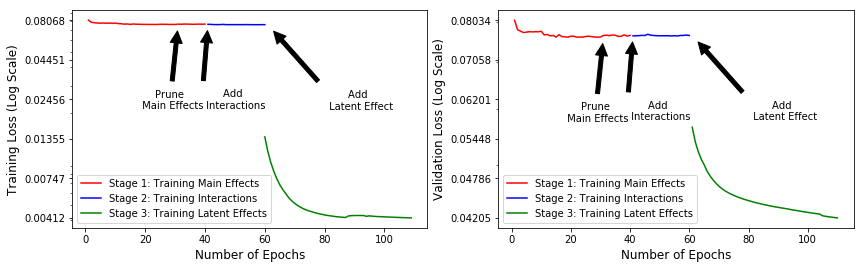

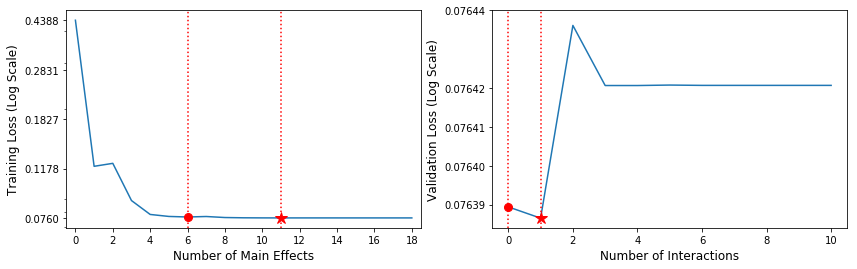

In [3]:
simu_dir = 'result'
data_dict_logs = model.final_gam_model.summary_logs(save_dict=False)
data_dict_logs.update({"err_train_mf":model.final_mf_model.mf_mae,
                       "err_val_mf":model.final_mf_model.mf_valmae})
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=False, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=False, save_eps=False)

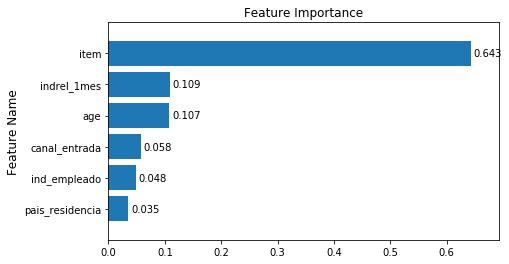

In [4]:
data_dict = model.final_gam_model.global_explain(0,save_dict=False)
feature_importance_visualize(data_dict, save_png=False, folder=simu_dir, name='s1_feature')

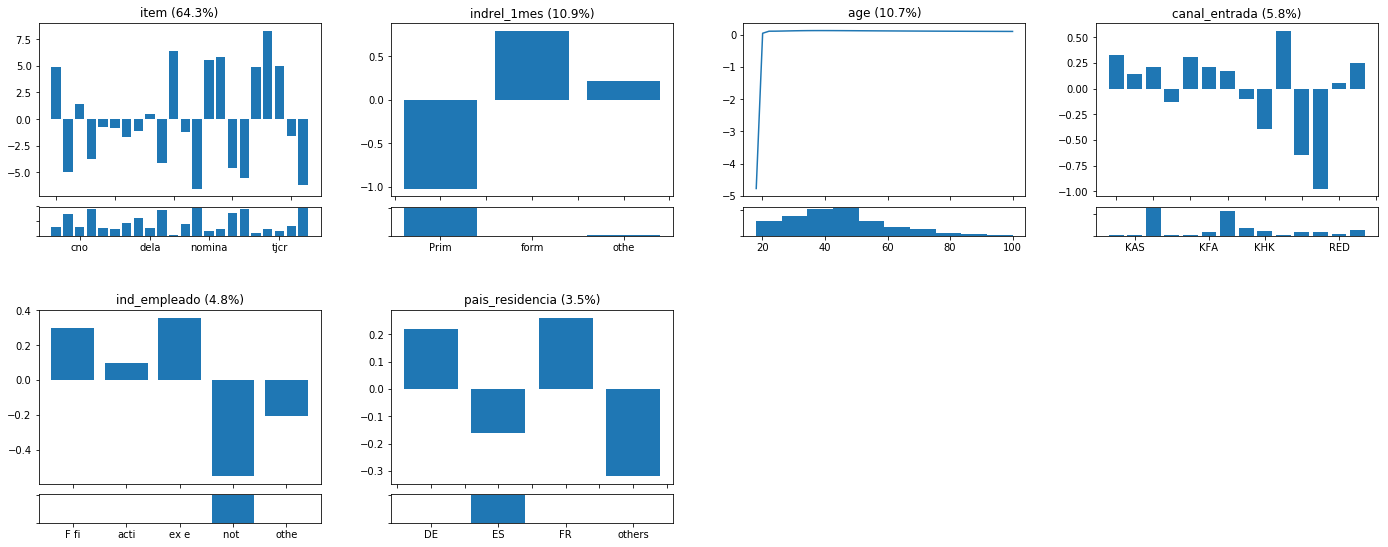

In [5]:
global_visualize_density(data_dict, save_png=False, folder=simu_dir, name='s1_global')

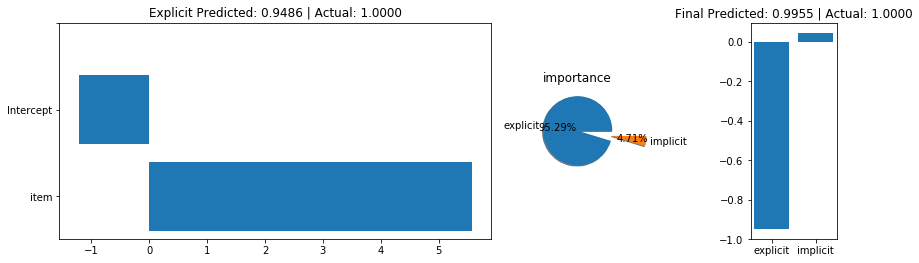

In [6]:
data_dict_local = model.local_explain(0,22,tr_x,tr_Xi,tr_y)
local_visualize(data_dict_local, save_png=False, folder=simu_dir, name='s1_local',task_type='Classification')

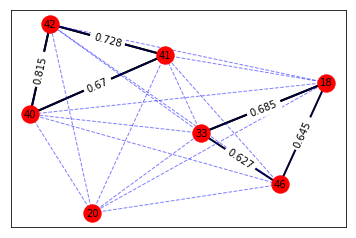

In [7]:
model.mf_distance(0.6,'user')

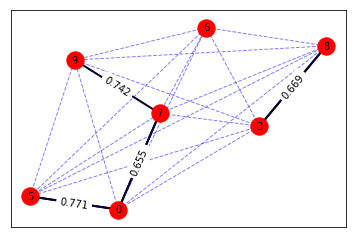

In [8]:
model.mf_distance(0.6,'item')

kid group: []
contain users: 350
mean : [ 2.75427562e-04 -3.37405405e-04 -2.13210731e-05 -7.26051878e-04
  3.37541931e-04]
std : [0.00543522 0.00468401 0.00541742 0.00632386 0.00415731]


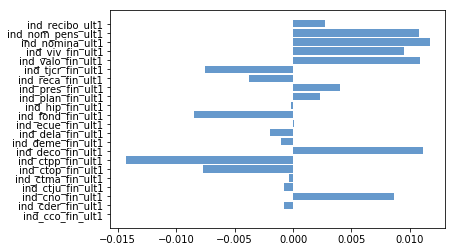

In [13]:
model.group_explain(42,'user')

kid group: [36, 30]
contain users: 7827
mean : [-1.47623475e-04  1.40334667e-04  5.41367465e-05  7.99819534e-06
  8.05794001e-05]
std : [0.00504987 0.00488697 0.00533823 0.00536103 0.00546153]


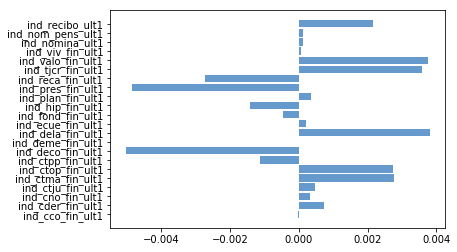

In [41]:
model.group_explain(40,'user')

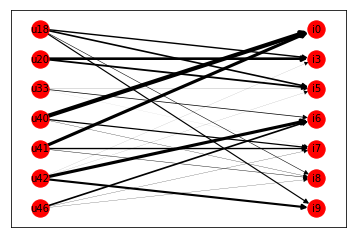

In [10]:
model.digraph('implicit',500)

In [11]:
new = te_x[14,:].reshape(1,-1)
_ = model.cold_start_analysis(new,'user',1.96)

The new user belong to group 46
 mean is [-7.27040278e-05 -2.99138120e-04 -9.99084076e-05  1.07521794e-04
  7.01893719e-05]
 and std is [0.00518702 0.00510058 0.00518316 0.00513605 0.00524539]
 the confidence interval is [[-0.01023926 -0.01029627 -0.01025889 -0.00995913 -0.01021078],[0.01009385 0.00969799 0.01005908 0.01017417 0.01035116]]
